#End-to-End Graph Regression with GINEConv + bond-length + target normalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
project_path = "/content/drive/MyDrive/GNN/GIN"
os.makedirs(project_path, exist_ok=True)
os.chdir(project_path)
print("Working directory:", os.getcwd())

Working directory: /content/drive/MyDrive/GNN/GIN


In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q torch-geometric
!pip install -q networkx pandas numpy matplotlib scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.6 MB/s eta 0:00:00


Imports & seeds

In [ ]:
import random
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool, BatchNorm
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


Synthetic graphene generator (positions, voids)

In [ ]:
NUM_SAMPLES = 1000
LATTICE_SIZE = 7          # 7x7 initial lattice
CC_BOND = 1.42            # Angstrom (C–C bond length in graphene)
BOND_THRESHOLD = 1.6      # Max bond distance in Å

In [ ]:
def create_graphene_lattice(size=7, void_fraction=0.0):
    """Generate hexagonal graphene lattice with voids (remove some atoms)."""
    a = CC_BOND
    positions_angstrom = []

    # Generate hexagonal coordinates in real Angstrom units
    for i in range(size):
        for j in range(size):
            x = a * (j + 0.5 * (i % 2))         # offset every other row
            y = a * np.sqrt(3) * i / 2
            positions_angstrom.append([x, y])

    positions_angstrom = np.array(positions_angstrom)
    num_total = len(positions_angstrom)

    # Introduce random voids (remove atoms)
    num_remove = int(void_fraction * num_total)
    if num_remove > 0:
        remove_idx = np.random.choice(num_total, num_remove, replace=False)
        positions_angstrom = np.delete(positions_angstrom, remove_idx, axis=0)

    # Normalize coordinates to [0,1] for plotting/model input
    positions_norm = (positions_angstrom - positions_angstrom.min(axis=0)) / (
        positions_angstrom.max(axis=0) - positions_angstrom.min(axis=0) + 1e-8
    )

    return positions_angstrom, positions_norm

In [ ]:
def create_graph_from_positions(positions_angstrom, bond_threshold=BOND_THRESHOLD):
    """Create bonds (edges) based on C–C distances."""
    G = nx.Graph()
    num_nodes = len(positions_angstrom)

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i, pos=positions_angstrom[i])

    # Add edges for nearby atoms (within cutoff)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            dist = np.linalg.norm(positions_angstrom[i] - positions_angstrom[j])
            if dist <= bond_threshold:
                G.add_edge(i, j, distance=dist)

    return G

Generate dataset

In [ ]:
data_rows = []
for i in tqdm(range(NUM_SAMPLES), desc="Generating samples"):
    void_fraction = np.round(np.random.uniform(0.0, 0.30), 3)

    pos_ang, pos_norm = create_graphene_lattice(size=LATTICE_SIZE, void_fraction=void_fraction)
    num_nodes = len(pos_ang)
    if num_nodes < 8:
        continue

    G = create_graph_from_positions(pos_ang, bond_threshold=BOND_THRESHOLD)

    degrees = [deg for _, deg in G.degree()]
    avg_degree = np.mean(degrees) if len(degrees) > 0 else 0.0

    # Physics-inspired property generation
    young_modulus = 1000.0 - 800.0 * void_fraction + np.random.normal(0, 20.0)
    young_modulus = max(100.0, young_modulus)
    fracture_strain = 0.25 - 0.20 * void_fraction + np.random.normal(0, 0.01)
    fracture_strain = max(0.02, fracture_strain)

    edges = [(u, v, d) for u, v, d in G.edges(data=True)]

    data_rows.append({
        "sample_id": i,
        "num_nodes": num_nodes,
        "positions": pos_norm.astype(np.float32),  # normalized for GNN input
        "edges": edges,
        "avg_degree": avg_degree,
        "void_fraction": float(void_fraction),
        "young_modulus": float(young_modulus),
        "fracture_strain": float(fracture_strain)
    })

df = pd.DataFrame(data_rows)
print(f"✅ Generated dataset: {len(df)} samples")
print(df[['sample_id', 'num_nodes', 'void_fraction', 'avg_degree',
          'young_modulus', 'fracture_strain']].head())

Generating samples: 100%|██████████| 1000/1000 [00:07<00:00, 133.47it/s]

✅ Generated dataset: 1000 samples
   sample_id  num_nodes  void_fraction  avg_degree  young_modulus  \
0          0         48          0.033    4.750000     961.638709   
1          1         40          0.198    4.050000     840.929196   
2          2         40          0.203    3.900000     852.681020   
3          3         43          0.137    4.511628     888.508227   
4          4         43          0.141    4.046512     878.561341   

   fracture_strain  
0         0.251123  
1         0.215052  
2         0.203604  
3         0.245673  
4         0.225772  


In [ ]:
df.head()

,sample_id,num_nodes,positions,edges,avg_degree,void_fraction,young_modulus,fracture_strain
0,0,48,"[[0.0, 0.0], [0.15384616, 0.0], [0.30769232, 0...","[(0, 1, {'distance': 1.42}), (0, 7, {'distance...",4.750000,0.033,961.638709,0.251123
1,1,40,"[[0.0, 0.0], [0.30769232, 0.0], [0.46153846, 0...","[(0, 5, {'distance': 1.42}), (1, 2, {'distance...",4.050000,0.198,840.929196,0.215052
2,2,40,"[[0.15384616, 0.0], [0.30769232, 0.0], [0.4615...","[(0, 1, {'distance': 1.42}), (0, 5, {'distance...",3.900000,0.203,852.681020,0.203604
3,3,43,"[[0.0, 0.0], [0.15384616, 0.0], [0.30769232, 0...","[(0, 1, {'distance': 1.42}), (0, 6, {'distance...",4.511628,0.137,888.508227,0.245673
4,4,43,"[[0.0, 0.0], [0.15384616, 0.0], [0.30769232, 0...","[(0, 1, {'distance': 1.42}), (1, 2, {'distance...",4.046512,0.141,878.561341,0.225772


Visualization

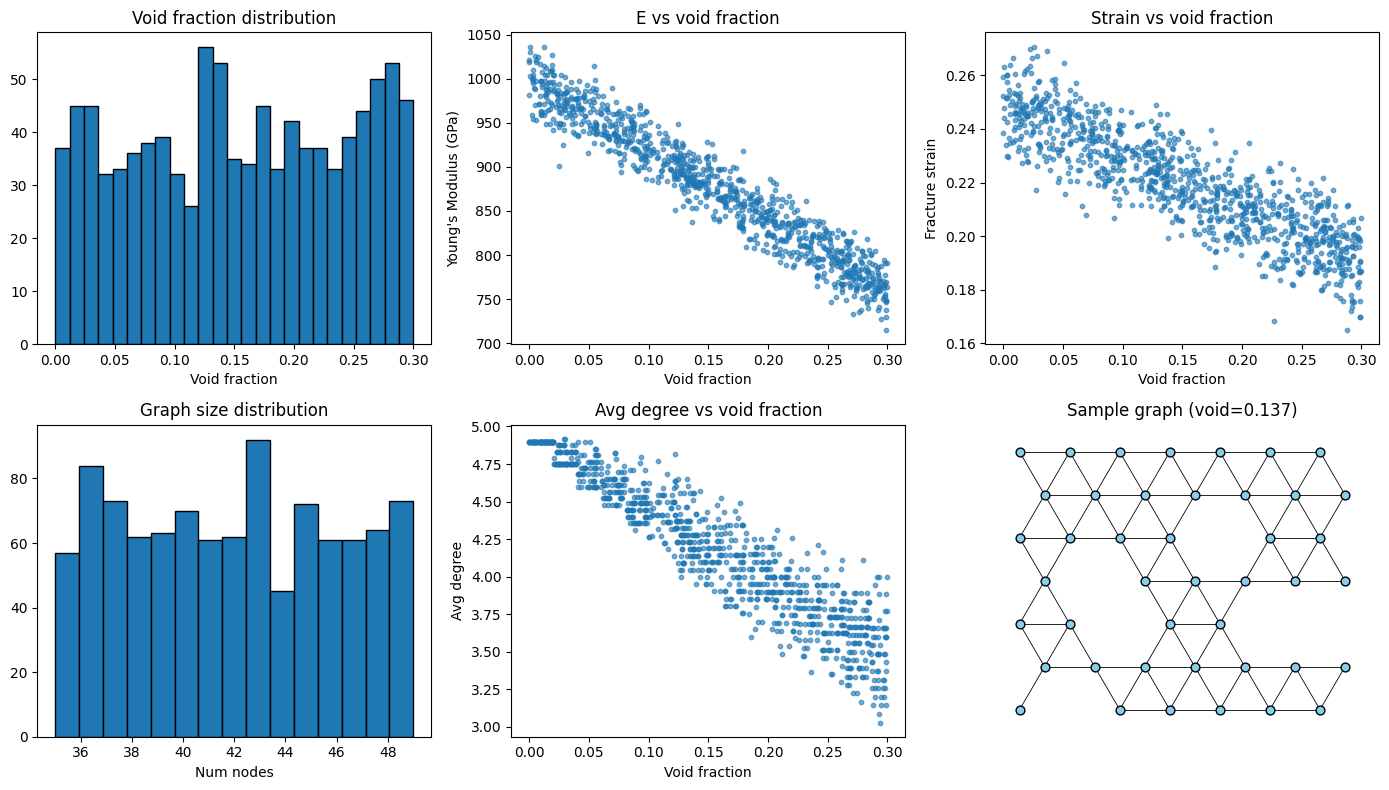

In [ ]:
plt.figure(figsize=(14,8))

# Void fraction distribution
plt.subplot(2,3,1)
plt.hist(df['void_fraction'], bins=25, edgecolor='black')
plt.xlabel('Void fraction'); plt.title('Void fraction distribution')

# Young's modulus vs void fraction
plt.subplot(2,3,2)
plt.scatter(df['void_fraction'], df['young_modulus'], s=10, alpha=0.6)
plt.xlabel('Void fraction'); plt.ylabel("Young's Modulus (GPa)"); plt.title("E vs void fraction")

# Fracture strain vs void fraction
plt.subplot(2,3,3)
plt.scatter(df['void_fraction'], df['fracture_strain'], s=10, alpha=0.6)
plt.xlabel('Void fraction'); plt.ylabel("Fracture strain"); plt.title("Strain vs void fraction")

# Number of nodes distribution
plt.subplot(2,3,4)
plt.hist(df['num_nodes'], bins=15, edgecolor='black')
plt.xlabel('Num nodes'); plt.title('Graph size distribution')

# Avg degree vs void fraction
plt.subplot(2,3,5)
plt.scatter(df['void_fraction'], df['avg_degree'], s=10, alpha=0.6)
plt.xlabel('Void fraction'); plt.ylabel('Avg degree'); plt.title('Avg degree vs void fraction')

# Show a sample graph
plt.subplot(2,3,6)
sample_idx = min(5, len(df)-1)
sample = df.iloc[sample_idx]
G = nx.Graph()
for i in range(len(sample['positions'])):
    G.add_node(i)
for (u,v,d) in sample['edges']:
    G.add_edge(u, v)
pos = {i: sample['positions'][i] for i in range(len(sample['positions']))}
nx.draw_networkx_nodes(G, pos, node_size=40, node_color='skyblue', edgecolors='black')
nx.draw_networkx_edges(G, pos, width=0.6)
plt.title(f"Sample graph (void={sample['void_fraction']:.3f})")
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir,"Viz.png"), dpi=200)
plt.show()

Convert to PyG Data objects with bond-length edge_attr

In [ ]:
graph_list = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Converting to PyG graphs"):
    positions = row['positions']            # (N,2)
    N = positions.shape[0]
    edge_tuples = row['edges']              # list of (u,v,attr)
    if len(edge_tuples) == 0:
        continue

    # --------------------------
    # Build edge_index & edge_attr
    # --------------------------
    edges = []
    edge_attrs = []
    for (u, v, d) in edge_tuples:
        # Euclidean distance (already normalized coords)
        dist = float(np.linalg.norm(positions[u] - positions[v]))
        # Undirected: add both directions
        edges.extend([[u, v], [v, u]])
        edge_attrs.extend([[dist], [dist]])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # shape [2, E]
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)              # shape [E, 1]

    # --------------------------
    # Node features: [x, y, degree, void_fraction]
    # --------------------------
    degrees = np.zeros((N, 1), dtype=np.float32)
    for n in range(N):
        degrees[n, 0] = sum(1 for (u, v, _) in edge_tuples if u == n or v == n)

    void_rep = np.full((N, 1), row['void_fraction'], dtype=np.float32)
    x = np.hstack([positions, degrees, void_rep])   # shape [N, 4]
    x = torch.tensor(x, dtype=torch.float)

    # --------------------------
    # Targets (graph-level)
    # --------------------------
    y_raw = np.array([row['young_modulus'], row['fracture_strain']], dtype=np.float32)
    y = torch.tensor(y_raw, dtype=torch.float).unsqueeze(0)  # shape [1, 2]

    # --------------------------
    # Create PyG Data object
    # --------------------------
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    graph_list.append(data)

print(f"Converted to PyG graphs: {len(graph_list)} samples")
print(graph_list[0])

Converting to PyG graphs: 100%|██████████| 1000/1000 [00:01<00:00, 979.04it/s]

Converted to PyG graphs: 1000 samples
Data(x=[48, 4], edge_index=[2, 228], edge_attr=[228, 1], y=[1, 2])


Train/Val/Test split AND target normalization (fit on train)

In [ ]:
train_graphs, temp_graphs = train_test_split(graph_list, test_size=0.30, random_state=SEED)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.50, random_state=SEED)
print(f"Splits: Train={len(train_graphs)}, Val={len(val_graphs)}, Test={len(test_graphs)}")

Splits: Train=700, Val=150, Test=150


In [ ]:
# Fit scaler on train targets
train_targets = np.vstack([g.y.numpy() for g in train_graphs])   # shape [n_train, 2]
scaler = StandardScaler().fit(train_targets)

In [ ]:
# Replace y in data objects with scaled targets (for training)
def apply_target_scaler(graphs, scaler):
    out = []
    for g in graphs:
        g2 = g.clone()
        raw = g2.y.numpy().reshape(1,2)
        scaled = scaler.transform(raw).astype(np.float32)
        g2.y = torch.tensor(scaled, dtype=torch.float)   # shape [1,2]
        out.append(g2)
    return out

In [ ]:
train_graphs_scaled = apply_target_scaler(train_graphs, scaler)
val_graphs_scaled   = apply_target_scaler(val_graphs, scaler)
test_graphs_scaled  = apply_target_scaler(test_graphs, scaler)

In [ ]:
processed_dir = "/content/drive/MyDrive/GNN/GIN/data/processed"
os.makedirs(processed_dir, exist_ok=True)
torch.save(train_graphs_scaled, os.path.join(processed_dir, "train_graphs.pt"))
torch.save(val_graphs_scaled, os.path.join(processed_dir, "val_graphs.pt"))
torch.save(test_graphs_scaled, os.path.join(processed_dir, "test_graphs.pt"))
print("Saved processed .pt files to Drive.")

Saved processed .pt files to Drive.


DataLoaders

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_graphs_scaled, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_graphs_scaled, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_graphs_scaled, batch_size=BATCH_SIZE, shuffle=False)

GNN model: multiple GINEConv layers + global mean pooling + MLP head

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, num_layers=2):
        super().__init__()
        layers = []
        dims = [in_channels] + [hidden]*(num_layers-1) + [out_channels]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [ ]:
class GINERegressor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.1, edge_dim=1):
        super(GINERegressor, self).__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        # --- First layer ---
        mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        conv = GINEConv(nn=mlp, edge_dim=edge_dim)
        self.convs.append(conv)
        self.norms.append(BatchNorm(hidden_channels))

        # --- Hidden layers ---
        for _ in range(num_layers - 1):
            mlp = nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels)
            )
            conv = GINEConv(nn=mlp, edge_dim=edge_dim)
            self.convs.append(conv)
            self.norms.append(BatchNorm(hidden_channels))

        # --- Regression head ---
        self.mlp_out = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_attr)
            x = norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = global_mean_pool(x, batch)
        return self.mlp_out(x)

In [ ]:
example = train_graphs_scaled[0]
in_channels = example.x.shape[1]
print("Node feature dim:", in_channels)

Node feature dim: 4


In [ ]:
in_channels = 4   # because node features are [x, y, degree, void_fraction]
model = GINERegressor(
    in_channels=in_channels,
    hidden_channels=512,
    out_channels=2,
    num_layers=5,
    dropout=0.1,
    edge_dim=1
).to(device)
print(model)

GINERegressor(
  (convs): ModuleList(
    (0): GINEConv(nn=Sequential(
      (0): Linear(in_features=4, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    ))
    (1-4): 4 x GINEConv(nn=Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    ))
  )
  (norms): ModuleList(
    (0-4): 5 x BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp_out): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)


Optimizer, scheduler, losses & helpers

In [ ]:
LR = 1e-3
WEIGHT_DECAY = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6)
loss_fn = torch.nn.MSELoss()

In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)  # pass full data object
        loss = loss_fn(pred, data.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [ ]:
@torch.no_grad()
def evaluate_raw_predictions(model, loader):
    model.eval()
    y_trues = []
    y_preds = []
    for data in loader:
        data = data.to(device)
        pred = model(data)  # pass full data object
        y_trues.append(data.y.cpu().numpy())
        y_preds.append(pred.cpu().numpy())
    return np.vstack(y_trues), np.vstack(y_preds)

In [ ]:
def inverse_scale(scaled_arr, scaler):
    return scaler.inverse_transform(scaled_arr)

In [ ]:
def compute_metrics_on_original_scale(y_true_orig, y_pred_orig, names=("young_modulus","fracture_strain")):
    metrics = {}
    for i, name in enumerate(names):
        true = y_true_orig[:, i]
        pred = y_pred_orig[:, i]
        mse = mean_squared_error(true, pred)
        mae = mean_absolute_error(true, pred)
        rmse = math.sqrt(mse)
        r2 = r2_score(true, pred)
        metrics[name] = {"mse": mse, "mae": mae, "rmse": rmse, "r2": r2}
    return metrics

Training loop with early stopping & checkpointing

In [ ]:
in_channels = 4   # e.g., [x, y, degree, void_fraction]
hidden_channels = 512
out_channels = 2
num_layers = 5
dropout = 0.1
LR = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 120
PATIENCE = 12
checkpoint_dir = "/content/drive/MyDrive/GNN/GIN/results"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
EPOCHS = 120
PATIENCE = 12
best_val_rmse = float('inf')
patience_counter = 0
checkpoint_dir = "/content/drive/MyDrive/GNN/GIN/results"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
model = GINERegressor(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    dropout=dropout
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6)
loss_fn = nn.MSELoss()

In [ ]:
best_val_rmse = float('inf')
patience_counter = 0
train_losses = []
val_rmse_history = []

In [ ]:
for epoch in trange(1, EPOCHS+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    train_losses.append(train_loss)

    ys_val_scaled, ypred_val_scaled = evaluate_raw_predictions(model, val_loader)
    ys_val_orig = inverse_scale(ys_val_scaled, scaler)
    ypred_val_orig = inverse_scale(ypred_val_scaled, scaler)

    metrics_val = compute_metrics_on_original_scale(ys_val_orig, ypred_val_orig)
    val_rmse = metrics_val['young_modulus']['rmse']
    val_mae  = metrics_val['young_modulus']['mae']
    val_r2   = metrics_val['young_modulus']['r2']

    val_rmse_history.append(val_rmse)
    scheduler.step(val_rmse)

    improved = ""
    if val_rmse < best_val_rmse - 1e-6:
        best_val_rmse = val_rmse
        patience_counter = 0
        ckpt_path = os.path.join(checkpoint_dir, "best_gine_regressor.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_rmse': val_rmse,
            'scaler': scaler
        }, ckpt_path)
        improved = "*"
    else:
        patience_counter += 1

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val RMSE(E): {val_rmse:.3f} | MAE: {val_mae:.3f} | R2: {val_r2:.4f} {improved}")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print("\nTraining finished.")
print(f"Best validation RMSE (Young's modulus): {best_val_rmse:.4f}")

  1%|          | 1/120 [00:01<03:02,  1.53s/it]

Epoch 001 | Train Loss: 0.3883 | Val RMSE(E): 67.427 | MAE: 56.985 | R2: 0.1573 *


  2%|▏         | 2/120 [00:02<02:06,  1.08s/it]

Epoch 002 | Train Loss: 0.2788 | Val RMSE(E): 180.454 | MAE: 163.325 | R2: -5.0363 


  2%|▎         | 3/120 [00:03<01:48,  1.08it/s]

Epoch 003 | Train Loss: 0.2935 | Val RMSE(E): 142.445 | MAE: 124.017 | R2: -2.7612 


  3%|▎         | 4/120 [00:03<01:32,  1.25it/s]

Epoch 004 | Train Loss: 0.2621 | Val RMSE(E): 49.613 | MAE: 41.033 | R2: 0.5437 *


  4%|▍         | 5/120 [00:04<01:20,  1.43it/s]

Epoch 005 | Train Loss: 0.2557 | Val RMSE(E): 132.878 | MAE: 115.198 | R2: -2.2729 


  5%|▌         | 6/120 [00:04<01:12,  1.57it/s]

Epoch 006 | Train Loss: 0.2826 | Val RMSE(E): 191.376 | MAE: 184.979 | R2: -5.7890 


  6%|▌         | 7/120 [00:05<01:07,  1.67it/s]

Epoch 007 | Train Loss: 0.2582 | Val RMSE(E): 64.976 | MAE: 53.950 | R2: 0.2174 


  7%|▋         | 8/120 [00:05<01:04,  1.74it/s]

Epoch 008 | Train Loss: 0.2565 | Val RMSE(E): 93.611 | MAE: 84.733 | R2: -0.6244 


  8%|▊         | 9/120 [00:06<01:01,  1.80it/s]

Epoch 009 | Train Loss: 0.2569 | Val RMSE(E): 83.216 | MAE: 79.756 | R2: -0.2836 


  8%|▊         | 10/120 [00:06<01:03,  1.73it/s]

Epoch 010 | Train Loss: 0.2417 | Val RMSE(E): 37.762 | MAE: 31.697 | R2: 0.7357 *


  9%|▉         | 11/120 [00:07<01:01,  1.78it/s]

Epoch 011 | Train Loss: 0.2327 | Val RMSE(E): 48.332 | MAE: 41.625 | R2: 0.5670 


 10%|█         | 12/120 [00:07<00:59,  1.83it/s]

Epoch 012 | Train Loss: 0.2375 | Val RMSE(E): 48.287 | MAE: 39.286 | R2: 0.5678 


 11%|█         | 13/120 [00:08<00:58,  1.84it/s]

Epoch 013 | Train Loss: 0.2250 | Val RMSE(E): 123.761 | MAE: 105.350 | R2: -1.8392 


 12%|█▏        | 14/120 [00:08<00:56,  1.86it/s]

Epoch 014 | Train Loss: 0.2447 | Val RMSE(E): 50.699 | MAE: 43.767 | R2: 0.5235 


 12%|█▎        | 15/120 [00:09<00:56,  1.87it/s]

Epoch 015 | Train Loss: 0.2186 | Val RMSE(E): 144.584 | MAE: 135.978 | R2: -2.8750 


 13%|█▎        | 16/120 [00:09<00:54,  1.91it/s]

Epoch 016 | Train Loss: 0.2629 | Val RMSE(E): 44.230 | MAE: 38.151 | R2: 0.6374 


 14%|█▍        | 17/120 [00:10<00:53,  1.91it/s]

Epoch 017 | Train Loss: 0.2612 | Val RMSE(E): 77.977 | MAE: 71.614 | R2: -0.1271 


 15%|█▌        | 18/120 [00:11<00:57,  1.77it/s]

Epoch 018 | Train Loss: 0.2218 | Val RMSE(E): 29.998 | MAE: 24.293 | R2: 0.8332 *


 16%|█▌        | 19/120 [00:11<00:56,  1.79it/s]

Epoch 019 | Train Loss: 0.2232 | Val RMSE(E): 67.370 | MAE: 61.409 | R2: 0.1587 


 17%|█▋        | 20/120 [00:12<00:53,  1.86it/s]

Epoch 020 | Train Loss: 0.2171 | Val RMSE(E): 58.764 | MAE: 53.356 | R2: 0.3599 


 18%|█▊        | 21/120 [00:12<00:56,  1.75it/s]

Epoch 021 | Train Loss: 0.2037 | Val RMSE(E): 26.479 | MAE: 21.150 | R2: 0.8700 *


 18%|█▊        | 22/120 [00:13<01:00,  1.61it/s]

Epoch 022 | Train Loss: 0.2094 | Val RMSE(E): 32.658 | MAE: 26.155 | R2: 0.8023 


 19%|█▉        | 23/120 [00:14<01:05,  1.47it/s]

Epoch 023 | Train Loss: 0.2137 | Val RMSE(E): 26.337 | MAE: 20.804 | R2: 0.8714 *


 20%|██        | 24/120 [00:15<01:06,  1.45it/s]

Epoch 024 | Train Loss: 0.2082 | Val RMSE(E): 42.256 | MAE: 34.347 | R2: 0.6690 


 21%|██        | 25/120 [00:15<01:05,  1.44it/s]

Epoch 025 | Train Loss: 0.1987 | Val RMSE(E): 34.346 | MAE: 28.182 | R2: 0.7813 


 22%|██▏       | 26/120 [00:16<01:02,  1.50it/s]

Epoch 026 | Train Loss: 0.2021 | Val RMSE(E): 41.835 | MAE: 36.376 | R2: 0.6756 


 22%|██▎       | 27/120 [00:16<00:58,  1.60it/s]

Epoch 027 | Train Loss: 0.1941 | Val RMSE(E): 109.072 | MAE: 105.086 | R2: -1.2052 


 23%|██▎       | 28/120 [00:17<00:53,  1.71it/s]

Epoch 028 | Train Loss: 0.2118 | Val RMSE(E): 27.613 | MAE: 22.129 | R2: 0.8587 


 24%|██▍       | 29/120 [00:17<00:51,  1.76it/s]

Epoch 029 | Train Loss: 0.1998 | Val RMSE(E): 49.407 | MAE: 41.500 | R2: 0.5475 


 25%|██▌       | 30/120 [00:18<00:50,  1.79it/s]

Epoch 030 | Train Loss: 0.2092 | Val RMSE(E): 67.235 | MAE: 63.128 | R2: 0.1620 


 26%|██▌       | 31/120 [00:19<00:51,  1.72it/s]

Epoch 031 | Train Loss: 0.1914 | Val RMSE(E): 24.306 | MAE: 18.805 | R2: 0.8905 *


 27%|██▋       | 32/120 [00:19<00:49,  1.78it/s]

Epoch 032 | Train Loss: 0.1890 | Val RMSE(E): 27.183 | MAE: 21.241 | R2: 0.8630 


 28%|██▊       | 33/120 [00:20<00:48,  1.81it/s]

Epoch 033 | Train Loss: 0.1954 | Val RMSE(E): 28.932 | MAE: 22.983 | R2: 0.8448 


 28%|██▊       | 34/120 [00:20<00:49,  1.72it/s]

Epoch 034 | Train Loss: 0.1908 | Val RMSE(E): 22.069 | MAE: 17.081 | R2: 0.9097 *


 29%|██▉       | 35/120 [00:21<00:48,  1.76it/s]

Epoch 035 | Train Loss: 0.1866 | Val RMSE(E): 31.547 | MAE: 25.683 | R2: 0.8155 


 30%|███       | 36/120 [00:21<00:47,  1.78it/s]

Epoch 036 | Train Loss: 0.2016 | Val RMSE(E): 36.391 | MAE: 31.046 | R2: 0.7545 


 31%|███       | 37/120 [00:22<00:45,  1.84it/s]

Epoch 037 | Train Loss: 0.2071 | Val RMSE(E): 26.532 | MAE: 21.002 | R2: 0.8695 


 32%|███▏      | 38/120 [00:22<00:44,  1.85it/s]

Epoch 038 | Train Loss: 0.1956 | Val RMSE(E): 33.328 | MAE: 27.651 | R2: 0.7941 


 32%|███▎      | 39/120 [00:23<00:42,  1.89it/s]

Epoch 039 | Train Loss: 0.1836 | Val RMSE(E): 23.113 | MAE: 18.272 | R2: 0.9010 


 33%|███▎      | 40/120 [00:23<00:42,  1.89it/s]

Epoch 040 | Train Loss: 0.1908 | Val RMSE(E): 31.775 | MAE: 26.020 | R2: 0.8128 


 34%|███▍      | 41/120 [00:24<00:41,  1.91it/s]

Epoch 041 | Train Loss: 0.1894 | Val RMSE(E): 24.809 | MAE: 19.229 | R2: 0.8859 


 35%|███▌      | 42/120 [00:25<00:40,  1.91it/s]

Epoch 042 | Train Loss: 0.1941 | Val RMSE(E): 30.622 | MAE: 25.168 | R2: 0.8262 


 36%|███▌      | 43/120 [00:25<00:40,  1.92it/s]

Epoch 043 | Train Loss: 0.1772 | Val RMSE(E): 22.991 | MAE: 18.185 | R2: 0.9020 


 37%|███▋      | 44/120 [00:26<00:39,  1.91it/s]

Epoch 044 | Train Loss: 0.1752 | Val RMSE(E): 27.275 | MAE: 21.765 | R2: 0.8621 


 38%|███▊      | 45/120 [00:26<00:43,  1.71it/s]

Epoch 045 | Train Loss: 0.1809 | Val RMSE(E): 22.924 | MAE: 17.633 | R2: 0.9026 


 38%|███▊      | 45/120 [00:27<00:46,  1.62it/s]

Epoch 046 | Train Loss: 0.1747 | Val RMSE(E): 26.377 | MAE: 21.074 | R2: 0.8710 
Early stopping triggered.

Training finished.
Best validation RMSE (Young's modulus): 22.0687


Load best model and evaluate on test set (inverse-scale outputs)

In [ ]:
ckpt_path = os.path.join(checkpoint_dir, "best_gine_regressor.pt")
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint not found at {ckpt_path}")

In [ ]:
with torch.serialization.safe_globals([StandardScaler]):
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)

# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
print("Loaded model and scaler from checkpoint.")

Loaded model and scaler from checkpoint.


In [ ]:
scaler = checkpoint['scaler']

In [ ]:
ys_test_scaled, ypred_test_scaled = evaluate_raw_predictions(model, test_loader)
ys_test_orig = inverse_scale(ys_test_scaled, scaler)
ypred_test_orig = inverse_scale(ypred_test_scaled, scaler)

In [ ]:
test_metrics = compute_metrics_on_original_scale(ys_test_orig, ypred_test_orig)
print("\nTest set metrics (original scale):")
for target, vals in test_metrics.items():
    print(f"\nTarget: {target}")
    for k, v in vals.items():
        print(f"  {k.upper():<6}: {v:.6f}")


Test set metrics (original scale):

Target: young_modulus
  MSE   : 444.972717
  MAE   : 17.075068
  RMSE  : 21.094376
  R2    : 0.918022

Target: fracture_strain
  MSE   : 0.000080
  MAE   : 0.007203
  RMSE  : 0.008964
  R2    : 0.789115


In [ ]:
# Save predictions CSV
preds_df = pd.DataFrame({
    'young_true': ys_test_orig[:,0],
    'young_pred': ypred_test_orig[:,0],
    'fract_true': ys_test_orig[:,1],
    'fract_pred': ypred_test_orig[:,1],
})

In [ ]:
preds_csv = os.path.join(checkpoint_dir, "gine_test_predictions.csv")
preds_df.to_csv(preds_csv, index=False)
print("Saved test predictions to:", preds_csv)

Saved test predictions to: /content/drive/MyDrive/GNN/GIN/results/gine_test_predictions.csv


Analyzing Predictions

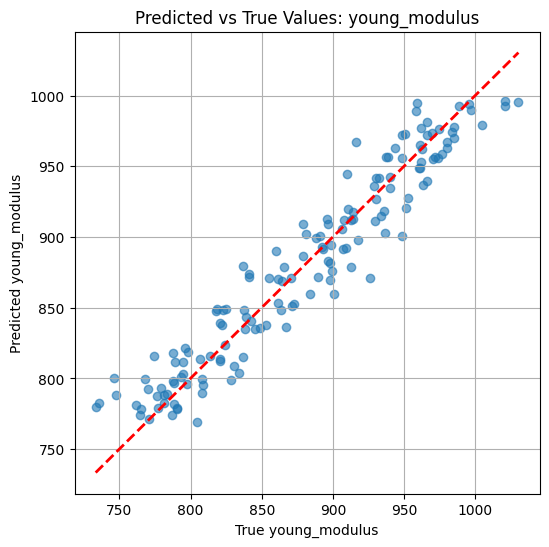

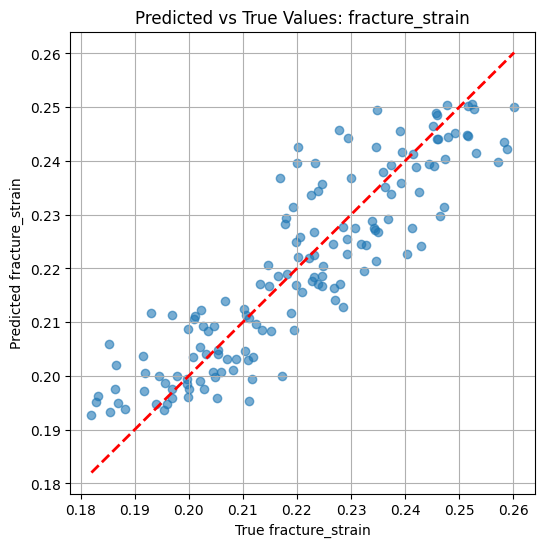

In [ ]:
targets = ['young_modulus', 'fracture_strain']

for i, target in enumerate(targets):
    plt.figure(figsize=(6,6))
    plt.scatter(ys_test_orig[:, i], ypred_test_orig[:, i], alpha=0.6)
    plt.plot([ys_test_orig[:, i].min(), ys_test_orig[:, i].max()],
             [ys_test_orig[:, i].min(), ys_test_orig[:, i].max()],
             color='red', linestyle='--', linewidth=2)
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Predicted vs True Values: {target}')
    plt.grid(True)
    plt.savefig(os.path.join(checkpoint_dir,"predicted_vs_true.png"), dpi=200)
    plt.show()

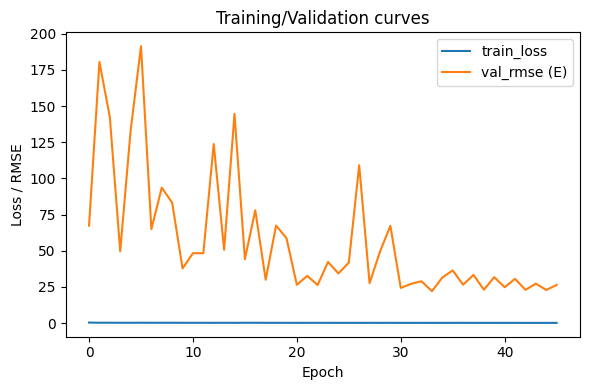

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='train_loss')
plt.plot(val_rmse_history, label='val_rmse (E)')
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.legend()
plt.title("Training/Validation curves")
plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir,"training_curves.png"), dpi=200)
plt.show()

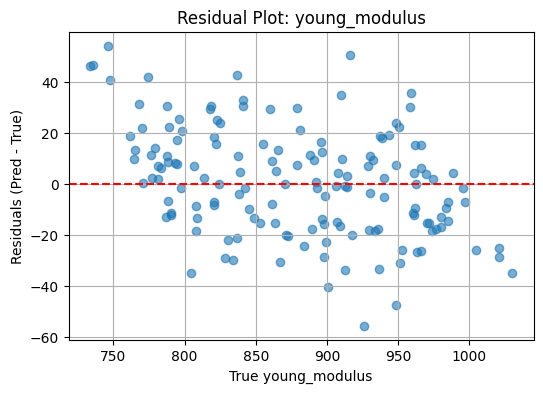

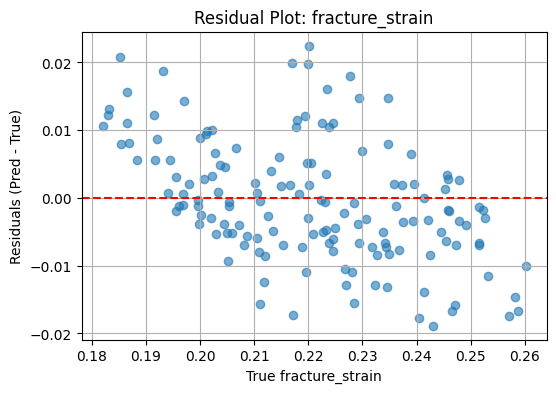

In [ ]:
for i, target in enumerate(targets):
    residuals = ypred_test_orig[:, i] - ys_test_orig[:, i]
    plt.figure(figsize=(6,4))
    plt.scatter(ys_test_orig[:, i], residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(f'True {target}')
    plt.ylabel('Residuals (Pred - True)')
    plt.title(f'Residual Plot: {target}')
    plt.grid(True)
    plt.savefig(os.path.join(checkpoint_dir,"Residual_plot.png"), dpi=200)
    plt.show()


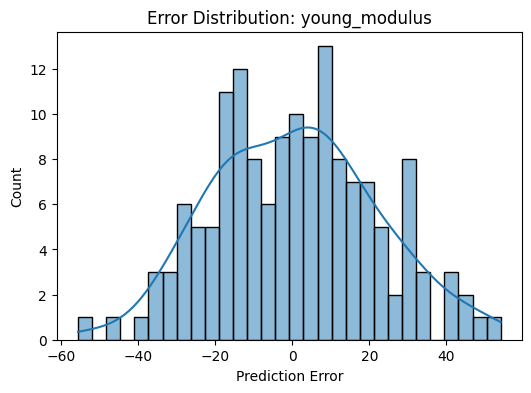

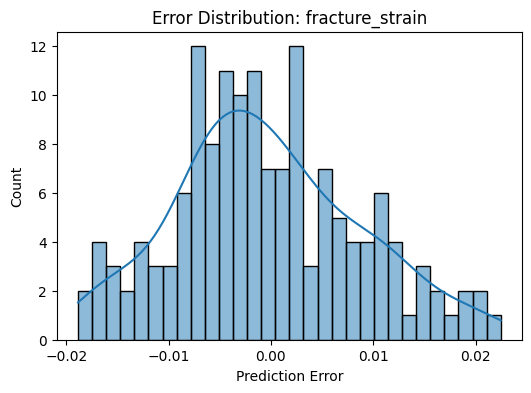

In [ ]:
import seaborn as sns

for i, target in enumerate(targets):
    errors = ypred_test_orig[:, i] - ys_test_orig[:, i]
    plt.figure(figsize=(6,4))
    sns.histplot(errors, bins=30, kde=True)
    plt.title(f'Error Distribution: {target}')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.savefig(os.path.join(checkpoint_dir,"Error_Distribution.png"), dpi=200)
    plt.show()


In [ ]:
metrics_csv = os.path.join(checkpoint_dir, "gine_test_metrics.csv")
metrics_df = pd.DataFrame({
    'target': list(test_metrics.keys()),
    'MSE': [v['mse'] for v in test_metrics.values()],
    'MAE': [v['mae'] for v in test_metrics.values()],
    'RMSE': [v['rmse'] for v in test_metrics.values()],
    'R2': [v['r2'] for v in test_metrics.values()]
})
metrics_df.to_csv(metrics_csv, index=False)
print("Saved test metrics to:", metrics_csv)

Saved test metrics to: /content/drive/MyDrive/GNN/GIN/results/gine_test_metrics.csv
